### Import Libraries

In [173]:
# Core data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# date time libraries
from datetime import date
from dateutil.relativedelta import relativedelta

# Time series analysis
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# Machine learning
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Handling warnings
import warnings

# Suppress only specific warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

pd.set_option('mode.chained_assignment', None) # Suppresses the warning

### Functions for Analysis

##### Data Processing

In [174]:
# Split our data
def split_data(dataset_input, data_col, test_size):
    # For final model evaluation - simple train/test split
    def train_test_split_ts(data, test_size=12):
        """
        Simple train/test split for time series
        """
        train_size = len(data) - test_size
        train_data = data.iloc[:train_size]
        test_data = data.iloc[train_size:]
        
        return train_data, test_data
    # Split your data
    train_name, test_name = train_test_split_ts(dataset_input[data_col], test_size=test_size)

    print(f"Train period: {train_name.index[0]} to {train_name.index[-1]}")
    print(f"Test period: {test_name.index[0]} to {test_name.index[-1]}")
    print(f"Train size: {len(train_name)} months")
    print(f"Test size: {len(test_name)} months")

    return train_name, test_name

##### Holt-Winters

In [175]:
# general model fitting function
def fit_model(data, train_data, test_data, trend, seasonal, damped_trend, 
              remove_bias=True, seasonal_periods=12, optimized=True):
    fitted_model = ExponentialSmoothing(
        train_data,
        trend=trend,           # Additive trend
        seasonal=seasonal,        # Multiplicative seasonality
        damped_trend=damped_trend,     # Damped trend
        seasonal_periods=seasonal_periods    # Monthly seasonality
        )

    # Fit with your best fitting parameters (use the ones that gave best results)
    fitted_model = fitted_model.fit(
        optimized=optimized,       # Let it optimize smoothing parameters
        remove_bias=remove_bias
        )
    # train data forecast values
    hw_train = fitted_model.fittedvalues

    # test data forecast values
    hw_forecast = fitted_model.forecast(steps=len(test_data))

    # Add to DataFrame
    data['hw_train'] = hw_train
    data['hw_forecast'] = hw_forecast

    ## Add in Columns to dataframe - also need to run test set to forecast on trained data

    return data

In [176]:
def hyperparameter_tuning(data):
    # Try simpler configurations
    simple_configs = [
        {'trend': None, 'seasonal': 'add', 'damped': False},
        {'trend': 'add', 'seasonal': 'add', 'damped': False},
        {'trend': 'add', 'seasonal': 'add', 'damped': True},
        {'trend': 'add', 'seasonal': None, 'damped': False},
        {'trend': None, 'seasonal': None, 'damped': False},
        {'trend': 'mul', 'seasonal': 'mul', 'damped': False},
        {'trend': 'mul', 'seasonal': 'mul', 'damped': True},
    ]
    results = []

    for config in simple_configs:
        model = ExponentialSmoothing(data, **config, seasonal_periods=12 if config['seasonal'] else None)
        fitted = model.fit(optimized=True, remove_bias=True)
        fitted_values = fitted.fittedvalues

        # Calculate performance
        stable_mape = np.mean(np.abs((data - fitted_values) / data)) * 100
        stable_r2 = r2_score(data, fitted_values)

        print("HYPERPARAMETERS: Trend: {} | Seasonal: {} | Damped: {} || RESULTS: Ratio: {:.2f} | R-squared: {:.2f} | MAPE: {:.2f}%".format(
        config['trend'], config['seasonal'], config['damped'], round(data.mean() / fitted_values.mean(), 4), round(stable_r2, 4), round(stable_mape, 4)))
        results.append({
            'order': [config['trend'], config['seasonal'], config['damped']],
            'r2': stable_r2,
            'mape': stable_mape
        })

        # Find hyperparameters
    best_hype = min(results, key=lambda x: x['mape'])
    print(f"\nBest ARIMA model: {best_hype['order']}")
    print(f"AIC: {best_hype['r2']:.2f}, MAPE: {best_hype['mape']:.2f}%")
    
    return best_hype['order']

##### ARIMA

In [177]:
def arima_training(train_data):

    # Test different p,q combinations (d=0 for stationary data)
    arima_configs = [(0,0,1), (1,0,0), (1,0,1), (2,0,1), (1,0,2), (2,0,2),
                     (0,1,1), (1,1,0), (1,1,1), (2,1,1), (1,1,2), (2,1,2)]
    results = []

    for p, d, q in arima_configs:
        model = ARIMA(train_data, order=(p, d, q))
        fitted_model = model.fit()
            
        # Generate forecast
        fitted_values = fitted_model.fittedvalues
            
        # Calculate performance
        mape = np.mean(np.abs((train_data - fitted_values) / train_data)) * 100
        aic = fitted_model.aic
            
        results.append({
                'order': (p, d, q),
                'aic': aic,
                'mape': mape,
                'forecast': fitted_values,
                'model': fitted_model
            })
            
        print(f"ARIMA{(p,d,q)}: AIC={aic:.1f}, MAPE={mape:.2f}%")
            

    # Find best model
    best_model = min(results, key=lambda x: x['aic'])
    print(f"\nBest ARIMA model: {best_model['order']}")
    print(f"AIC: {best_model['aic']:.1f}, MAPE: {best_model['mape']:.2f}%")
    return best_model['order']

In [178]:
# Add arima_train and arima_forecast and arima (with all fitted values) to df
def arima_forecast(data, train_data, test_data, best_model):
    # Fit the best model from the ARIMA process
    best_arima = ARIMA(train_data, order=best_model)
    best_fitted = best_arima.fit()

    # Generate forecasts
    arima_fitted_values = best_fitted.fittedvalues
    arima_forecast = best_fitted.forecast(steps=len(test_data))
  

    # Get the last fitted value as starting point
    

    arima_train = pd.Series(arima_fitted_values, index=train_data.index)
    arima_test = pd.Series(arima_forecast, index=test_data.index)

    # Add to DataFrame
    data['arima_train'] = arima_train
    data['arima_forecast'] = arima_test

    if data['arima_train'][0] == 0:
        data['arima_train'][0] = np.nan

    return data


##### SARIMA

In [179]:
def sarima_training(train_data):
    # Test multiple SARIMA configurations
    # Corrected SARIMA configurations - (p,d,q)(P,D,Q,s) where s=12
    sarima_configs = [
        (1,0,0,1,0,1,12),  # SARIMA(1,0,0)(1,0,1,12)
        (1,0,1,1,0,1,12),  # SARIMA(1,0,1)(1,0,1,12)  
        (0,0,1,1,0,1,12),  # SARIMA(0,0,1)(1,0,1,12)
        (2,0,1,1,0,1,12),  # SARIMA(2,0,1)(1,0,1,12)
        (1,0,0,0,0,1,12),  # SARIMA(1,0,0)(0,0,1,12)
    ]

    sarima_results = []

    for p,d,q,P,D,Q,s in sarima_configs:
        # Fit SARIMA model
        model = SARIMAX(train_data, 
                        order=(p,d,q), 
                        seasonal_order=(P,D,Q,s))
        fitted_model = model.fit()
            
        # Generate forecast
        fitted_values = fitted_model.fittedvalues
            
        # Calculate metrics
        mape = np.mean(np.abs((train_data - fitted_values) / train_data)) * 100
        aic = fitted_model.aic
            
        sarima_results.append({
                'order': (p,d,q),
                'seasonal_order': (P,D,Q,s),
                'aic': aic,
                'mape': mape,
                'forecast': fitted_values,
                'model': fitted_model
        })
            
        print(f"SARIMA({p},{d},{q})({P},{D},{Q},{s}): AIC={aic:.1f}, MAPE={mape:.2f}% | Forecast range: ${fitted_values.min():,.0f} to ${fitted_values.max():,.0f}")
            

    best_sarima = min(sarima_results, key=lambda x: x['aic'])
    print(f"\nBest SARIMA model: {best_sarima['order']}{best_sarima['seasonal_order']}")
    print(f"AIC: {best_sarima['aic']:.1f}, MAPE: {best_sarima['mape']:.2f}%")

    return best_sarima['order'], best_sarima['seasonal_order']

In [180]:
def sarima_forecast(data, train_data, test_data, best_sarima, best_seasonal_order):
    # Fit best SARIMA   
    best_sarima = SARIMAX(train_data, 
                        order=best_sarima, 
                        seasonal_order=best_seasonal_order)
    best_fitted = best_sarima.fit()

    # Generate forecasts with confidence intervals
    sarima_forecast = best_fitted.forecast(steps=len(test_data))
    sarima_fitted_values = best_fitted.fittedvalues

    sarima_train = pd.Series(sarima_fitted_values, index=train_data.index)
    sarima_forecast = pd.Series(sarima_forecast, index=test_data.index)

    # Add to DataFrame
    data['sarima_train'] = sarima_train
    data['sarima_forecast'] = sarima_forecast

    if data['sarima_train'][0] == 0:
        data['sarima_train'][0] = np.nan

    return data

##### Testing Values

In [181]:
# Output to test forecasted values
def test_fitted_values(actual_data, forecast_data):
# Calculate performance
    stable_mape = np.mean(np.abs((actual_data - forecast_data) / actual_data)) * 100
    stable_r2 = r2_score(actual_data, forecast_data)
    direction_accuracy = np.mean(np.sign(actual_data.diff()) == np.sign(forecast_data.diff())) * 100
    print(f"MAPE: {stable_mape:.2f}%")
    print(f"R²: {stable_r2:.3f}")
    print(f"Directional Accuracy: {direction_accuracy:.2f}%")

##### Time Series Plotting

In [182]:
def linear_regression(data, col):
    time_index = np.arange(len(data)).reshape(-1, 1)
    col = 'data'

    # Add trend line
    # Fit model
    model = LinearRegression()
    model.fit(time_index, data[col].values)

    # Generate predictions
    trend_line = model.predict(time_index)
    return trend_line

In [183]:
def plot_data(data, col, yticks, colors, title, ylabel, 
                trend_line=False, hw = False, arima=False, sarima=False):

    # Plot Credit Spread Data
    fig, ax = plt.subplots(figsize=(16,8))

    ax.plot(data.index, data['{}'.format(col)], linewidth=2, color=colors[0], label="{}".format(ylabel))

    if trend_line == True:
        # Add trend line
        lr = linear_regression(data, col)
        ax.plot(data.index, lr, linestyle = "--", color= colors[1], alpha=0.8, linewidth=2, label = "Trend Line")
        

    if hw == True:
        ax.plot(data.index, data['hw_train'], linestyle="--", color=colors[2], alpha=0.8, linewidth=3, label="HW Fit")
        ax.plot(data.index, data['hw_forecast'], linestyle="dotted", color=colors[3], alpha=0.8, linewidth=3, label="HW Forecast")

    if arima == True:
        ax.plot(data.index, data['arima_train'], linestyle="--", color=colors[2], alpha=0.8, linewidth=3, label="ARIMA Fit")
        ax.plot(data.index, data['arima_forecast'], linestyle="dotted", color=colors[3], alpha=0.8, linewidth=3, label="ARIMA Forecast")

    if sarima == True:
        ax.plot(data.index, data['sarima_train'], linestyle="--", color=colors[2], alpha=0.8, linewidth=3, label="SARIMA Fit")
        ax.plot(data.index, data['sarima_forecast'], linestyle="dotted", color=colors[3], alpha=0.8, linewidth=3, label="SARIMA Forecast")

    ax.set_ylabel(ylabel, fontsize=14, fontweight='bold')
    ax.set_xlabel('Month End', fontsize=14, fontweight='bold')
    ax.set_yticks(yticks, yticks, fontsize=12)
    ax.tick_params(axis='x', size=12)

    # Position legend between title and plot
    plt.title(title, size=16, fontweight='bold', pad=34)  # Add pad for spacing
    plt.legend(bbox_to_anchor=(0.5, 1.08), loc='upper center', ncol=6, fontsize=12)
    plt.subplots_adjust(top=0.80)  # Make more room at the top
    plt.ylim(min(yticks)-(min(yticks)*.05), max(yticks))
    
    # Add Y-axis grid lines
    plt.grid(axis='y')

    if trend_line == True:
        plt.savefig(f'{title}_trend_line.png', dpi=300)

    plt.show();

##### Create Month-End Date Index

In [184]:
# create a set of month-end dates

# Define the start and end dates for your range
end_date = date(2025, 6, 30)
start_date = end_date-relativedelta(months=99)

# Generate the range of month-end dates
# The 'M' frequency alias specifies month-end dates
stationary_month_end_dates = pd.date_range(start=start_date, end=end_date, freq='ME')

start_date = end_date-relativedelta(months=113)
non_stationary_month_end_dates = pd.date_range(start=start_date, end=end_date, freq='ME')

In [185]:
non_stationary_month_end_dates.min()

Timestamp('2016-01-31 00:00:00')

### Stationary

##### Generate Synthetic Stationary Data Set

In [186]:
# Base stationary series
np.random.seed(42)  # For reproducibility
n_periods = 100  # 5 years monthly
base_series = np.random.normal(0, 1, n_periods)  # Mean-reverting around 0

# Add some autocorrelation to make it more realistic
for i in range(1, len(base_series)):
    base_series[i] = 0.3 * base_series[i-1] + 0.7 * base_series[i]

# Scale to realistic financial metric (maybe credit spreads in basis points)
stationary_data = 250 + base_series * 50  # Mean of 250bp, std ~50bp

# Inject extremes at specific periods
extreme_periods = [15, 32, 65]  # Month 15, 32, 45
extreme_values = [450, 100, 380]  # Spike up, crash down, spike up

for period, value in zip(extreme_periods, extreme_values):
    stationary_data[period] = value


stationary = pd.DataFrame()
stationary['data'] = stationary_data
stationary['me_dates'] = stationary_month_end_dates
stationary = stationary.set_index('me_dates')

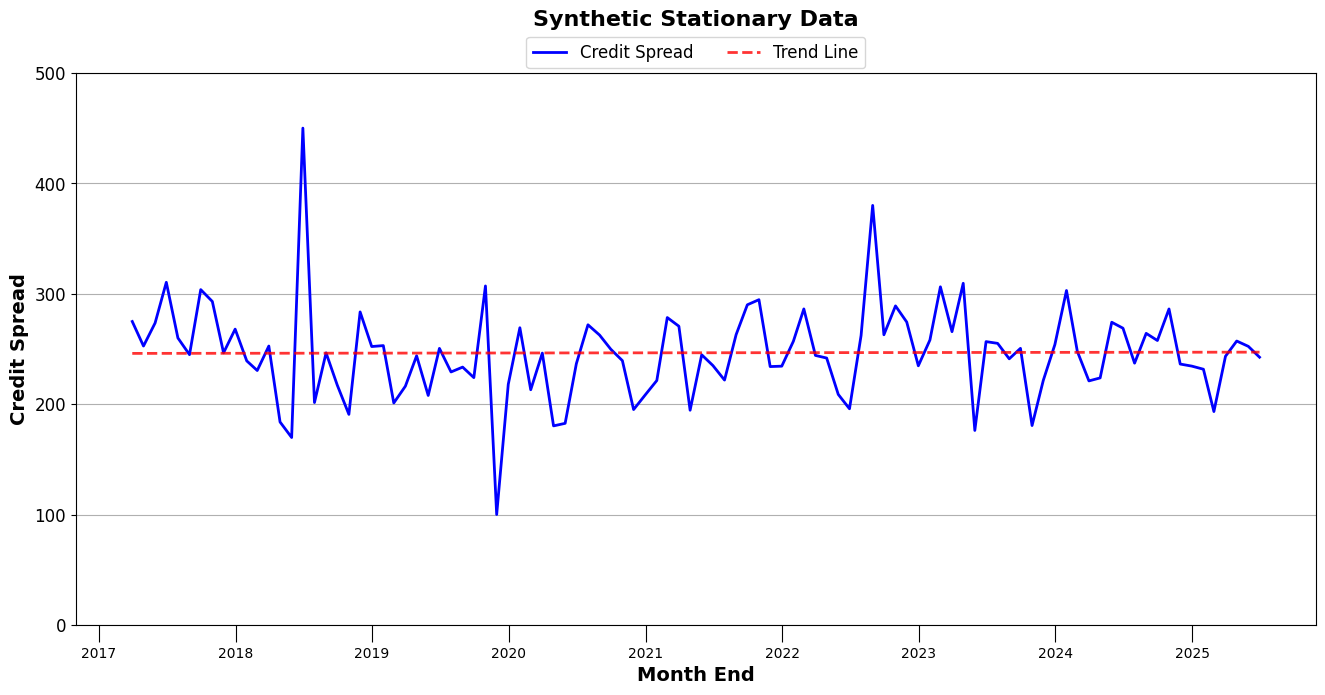

In [187]:
# Plot Ccomponents
title = "Synthetic Stationary Data"
yticks = [0, 100, 200, 300, 400, 500]
colors= ["Blue", "red", "#ff2600", "#ff6700", "#ff8d00", "#ffac00", "#ffc800"]

plot_data(stationary, 'data', yticks, colors, title, 'Credit Spread', trend_line=True)

In [188]:
result = adfuller(stationary['data'])

print(f"ADF Test Results for Stationary Data:")
print(f"ADF Statistic: {result[0]:.6f}")
print(f"p-value: {result[1]:.6f}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"\t{key}: {value:.3f}")
    
# Interpretation
if result[1] <= 0.05:
    print("Result: STATIONARY (reject null hypothesis)")
else:
    print("Result: NON-STATIONARY (fail to reject null hypothesis)")

ADF Test Results for Stationary Data:
ADF Statistic: -10.045782
p-value: 0.000000
Critical Values:
	1%: -3.498
	5%: -2.891
	10%: -2.583
Result: STATIONARY (reject null hypothesis)


##### Forecasting Holt-Winters

In [189]:
## Split the data for all future models
train_data, test_data = split_data(stationary, 'data', 20)

Train period: 2017-03-31 00:00:00 to 2023-10-31 00:00:00
Test period: 2023-11-30 00:00:00 to 2025-06-30 00:00:00
Train size: 80 months
Test size: 20 months


In [190]:
best_hype = hyperparameter_tuning(train_data)

HYPERPARAMETERS: Trend: None | Seasonal: add | Damped: False || RESULTS: Ratio: 1.00 | R-squared: 0.15 | MAPE: 13.56%
HYPERPARAMETERS: Trend: add | Seasonal: add | Damped: False || RESULTS: Ratio: 1.00 | R-squared: 0.13 | MAPE: 13.24%
HYPERPARAMETERS: Trend: add | Seasonal: add | Damped: True || RESULTS: Ratio: 1.00 | R-squared: 0.20 | MAPE: 13.07%
HYPERPARAMETERS: Trend: add | Seasonal: None | Damped: False || RESULTS: Ratio: 1.00 | R-squared: 0.00 | MAPE: 14.25%
HYPERPARAMETERS: Trend: None | Seasonal: None | Damped: False || RESULTS: Ratio: 1.00 | R-squared: -0.00 | MAPE: 14.25%
HYPERPARAMETERS: Trend: mul | Seasonal: mul | Damped: False || RESULTS: Ratio: 1.00 | R-squared: 0.15 | MAPE: 13.56%
HYPERPARAMETERS: Trend: mul | Seasonal: mul | Damped: True || RESULTS: Ratio: 1.00 | R-squared: 0.20 | MAPE: 13.06%

Best ARIMA model: ['mul', 'mul', True]
AIC: 0.20, MAPE: 13.06%


In [191]:
# Fit the Model
stationary = fit_model(stationary, train_data, test_data, best_hype[0], best_hype[1], best_hype[2])
    

In [192]:
# test the fitted values for the training dataset
test_fitted_values(stationary['data'][:-20], stationary['hw_train'][:-20])

MAPE: 13.06%
R²: 0.197
Directional Accuracy: 63.75%


In [193]:
# Test the forecasted values
test_fitted_values(stationary['data'][-20:], stationary['hw_forecast'][-20:])

MAPE: 19.02%
R²: -4.492
Directional Accuracy: 40.00%


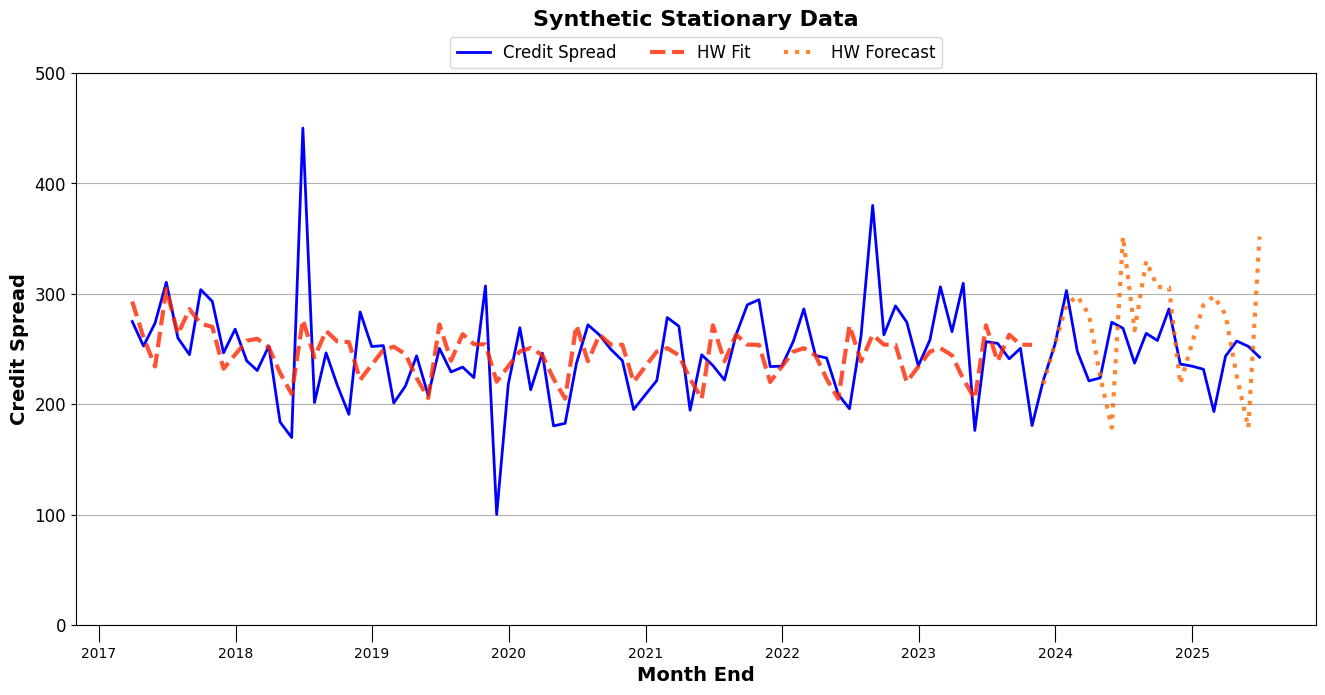

In [194]:
plot_data(stationary, 'data', yticks, colors, title, 'Credit Spread', hw=True)

##### ARIMA

In [195]:
best_model = arima_training(train_data)
stationary = arima_forecast(stationary, train_data, test_data, best_model)

ARIMA(0, 0, 1): AIC=846.8, MAPE=14.34%
ARIMA(1, 0, 0): AIC=846.8, MAPE=14.34%
ARIMA(1, 0, 1): AIC=848.8, MAPE=14.35%
ARIMA(2, 0, 1): AIC=850.0, MAPE=14.24%
ARIMA(1, 0, 2): AIC=850.0, MAPE=14.24%
ARIMA(2, 0, 2): AIC=849.6, MAPE=13.78%
ARIMA(0, 1, 1): AIC=839.4, MAPE=15.95%
ARIMA(1, 1, 0): AIC=870.1, MAPE=18.60%
ARIMA(1, 1, 1): AIC=840.8, MAPE=16.07%
ARIMA(2, 1, 1): AIC=841.7, MAPE=16.03%
ARIMA(1, 1, 2): AIC=843.3, MAPE=15.83%
ARIMA(2, 1, 2): AIC=843.4, MAPE=15.70%

Best ARIMA model: (0, 1, 1)
AIC: 839.4, MAPE: 15.95%


In [196]:
# test the fitted values for the training dataset
test_fitted_values(stationary['data'][1:-20], stationary['arima_train'][1:-20])

MAPE: 14.89%
R²: -0.043
Directional Accuracy: 30.38%


In [197]:
# Test the forecasted values
test_fitted_values(stationary['data'][-20:], stationary['arima_forecast'][-20:])

MAPE: 7.93%
R²: -0.008
Directional Accuracy: 0.00%


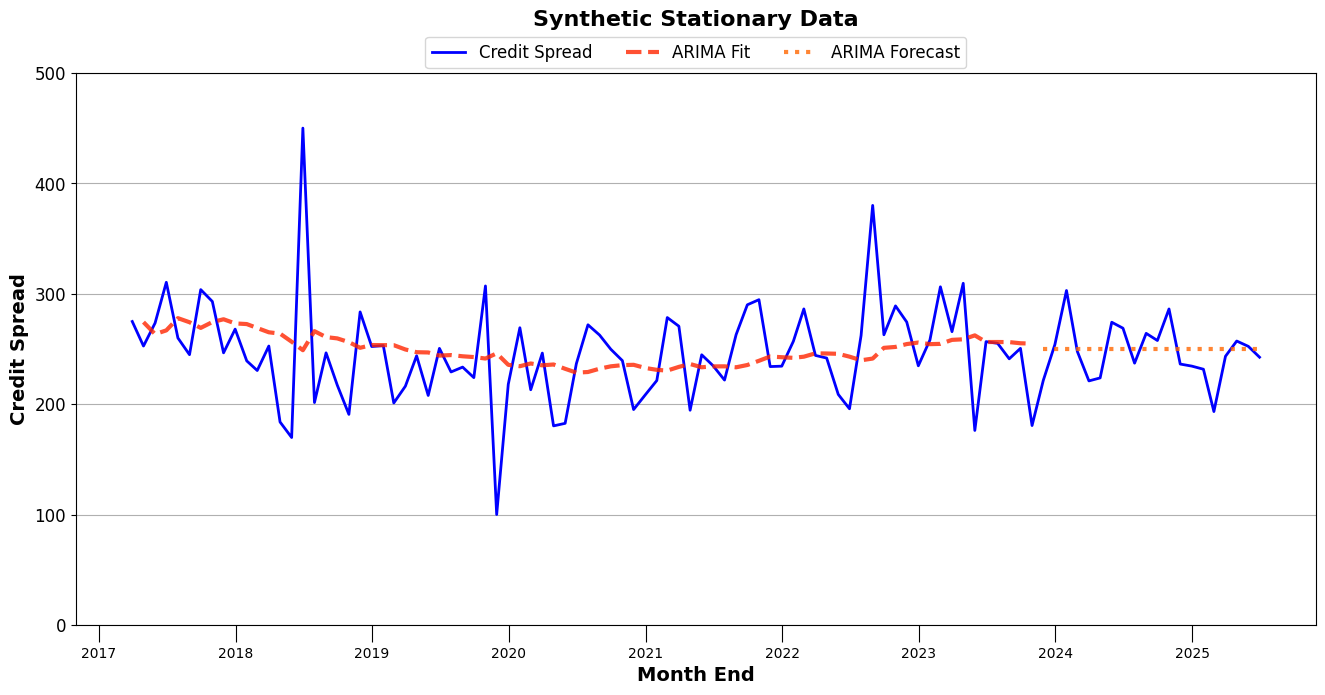

In [198]:
plot_data(stationary, 'data', yticks, colors, title, 'Credit Spread', arima=True)

SARIMA

In [199]:
best_model, best_seasonal_order = sarima_training(train_data)
stationary = sarima_forecast(stationary, train_data, test_data, best_model, best_seasonal_order)

SARIMA(1,0,0)(1,0,1,12): AIC=906.6, MAPE=20.22% | Forecast range: $0 to $418
SARIMA(1,0,1)(1,0,1,12): AIC=857.6, MAPE=15.80% | Forecast range: $0 to $276
SARIMA(0,0,1)(1,0,1,12): AIC=908.9, MAPE=28.61% | Forecast range: $0 to $373
SARIMA(2,0,1)(1,0,1,12): AIC=860.5, MAPE=15.87% | Forecast range: $0 to $275
SARIMA(1,0,0)(0,0,1,12): AIC=905.7, MAPE=19.96% | Forecast range: $0 to $427

Best SARIMA model: (1, 0, 1)(1, 0, 1, 12)
AIC: 857.6, MAPE: 15.80%


In [200]:
# test the fitted values for the training dataset
test_fitted_values(stationary['data'][1:-20], stationary['sarima_train'][1:-20])

MAPE: 14.73%
R²: -0.014
Directional Accuracy: 44.30%


In [201]:
# Test the forecasted values
test_fitted_values(stationary['data'][-20:], stationary['sarima_forecast'][-20:])

MAPE: 8.85%
R²: -0.219
Directional Accuracy: 40.00%


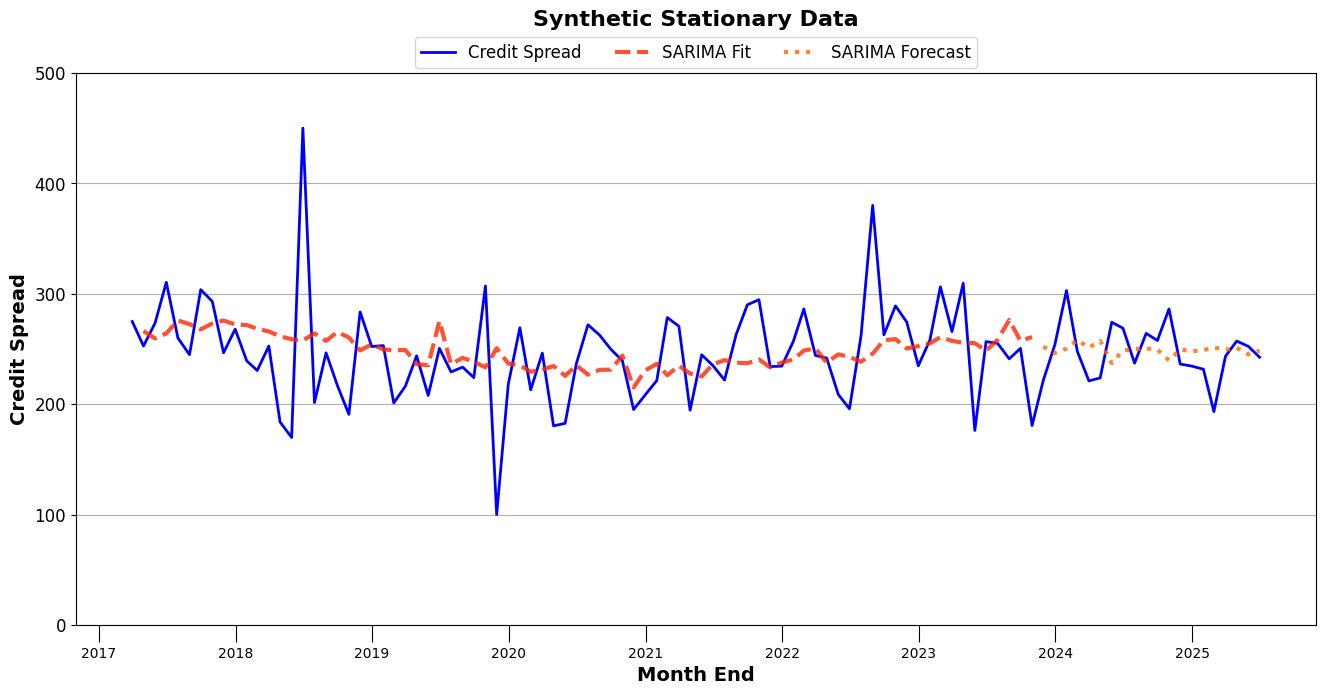

In [202]:
plot_data(stationary, 'data', yticks, colors, title, 'Credit Spread', sarima=True)

### Non-Stationary

##### Generate Synthetic Non-Stationary Data

In [203]:
# Parameters
n_periods = 114  # 8.5 years monthly
flat_rate = 0.001  # 0.1% monthly flat rate
mid_rate = 0.003  # 0.3% monthly mid rate
growth_rate = 0.004  # 0.4% monthly growth
np.random.seed(42)

# Periods 
flat_periods = int(round(n_periods*0.3, 0))
mid_periods = int(round(n_periods*0.35, 0))
growth_periods = n_periods - flat_periods - mid_periods

# Generate base flat period
flat_time = np.arange(flat_periods)
flat_period = 400000 * np.exp(flat_rate * flat_time)

mid_time = np.arange(mid_periods)
mid_period = (max(flat_period)*1.01) * np.exp(mid_rate * mid_time)

growth_time = np.arange(growth_periods)
growth_period = (max(mid_period)*1.035) * np.exp(growth_rate * growth_time)

# generate flat data
flat_noise_factor = 0.01  # 1% volatility
flat_noise = np.random.normal(0, flat_noise_factor, flat_periods)
flat_data = flat_period * (1 + flat_noise)

# Add realistic noise (proportional to level - heteroskedastic)
mid_noise_factor = 0.015  # 1.5% volatility
mid_noise = np.random.normal(0, mid_noise_factor, mid_periods)
mid_data = mid_period * (1 + mid_noise)

# Add realistic noise (proportional to level - heteroskedastic)
growth_noise_factor = 0.025  # 2.5% volatility
growth_noise = np.random.normal(0, growth_noise_factor, growth_periods)
growth_data = growth_period * (1 + growth_noise)

exponential_data = pd.concat([pd.Series(flat_data), pd.Series(mid_data), pd.Series(growth_data)])

non_stationary = pd.DataFrame()
non_stationary['data'] = exponential_data
non_stationary['me_dates'] = non_stationary_month_end_dates
non_stationary = non_stationary.set_index('me_dates')

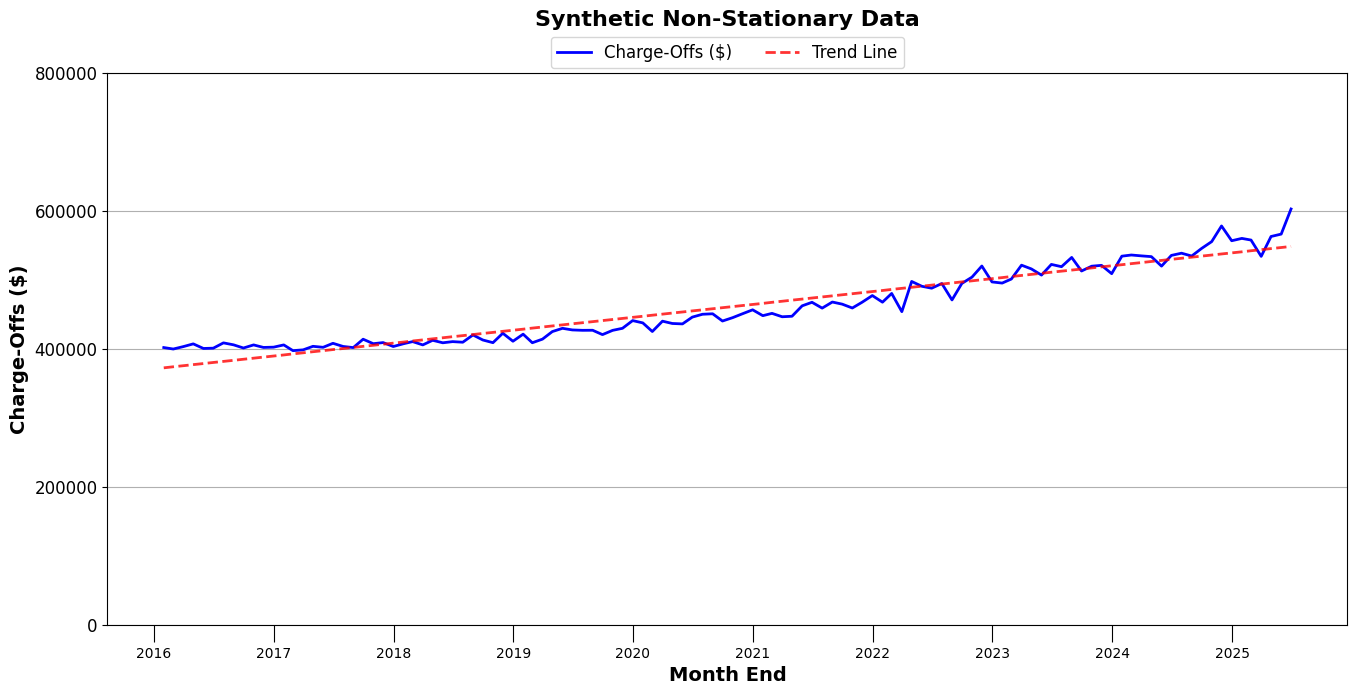

In [204]:
# Plot Ccomponents
title = "Synthetic Non-Stationary Data"
yticks = [0, 200000, 400000, 600000, 800000]
colors= ["Blue", "red", "#ff2600", "#ff6700", "#ff8d00", "#ffac00", "#ffc800"]

plot_data(non_stationary, 'data', yticks, colors, title, 'Charge-Offs ($)', trend_line=True)

In [205]:
result = adfuller(non_stationary['data'])

print(f"ADF Test Results for Stationary Data:")
print(f"ADF Statistic: {result[0]:.6f}")
print(f"p-value: {result[1]:.6f}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"\t{key}: {value:.3f}")
    
# Interpretation
if result[1] <= 0.05:
    print("Result: STATIONARY (reject null hypothesis)")
else:
    print("Result: NON-STATIONARY (fail to reject null hypothesis)")

ADF Test Results for Stationary Data:
ADF Statistic: 1.898435
p-value: 0.998525
Critical Values:
	1%: -3.497
	5%: -2.891
	10%: -2.582
Result: NON-STATIONARY (fail to reject null hypothesis)


##### Holt-Winters

In [206]:
## Split the data for all future models
train_data, test_data = split_data(non_stationary, 'data', 24)

Train period: 2016-01-31 00:00:00 to 2023-06-30 00:00:00
Test period: 2023-07-31 00:00:00 to 2025-06-30 00:00:00
Train size: 90 months
Test size: 24 months


In [207]:
best_hype = hyperparameter_tuning(train_data)

HYPERPARAMETERS: Trend: None | Seasonal: add | Damped: False || RESULTS: Ratio: 1.00 | R-squared: 0.95 | MAPE: 1.33%
HYPERPARAMETERS: Trend: add | Seasonal: add | Damped: False || RESULTS: Ratio: 1.00 | R-squared: 0.96 | MAPE: 1.12%
HYPERPARAMETERS: Trend: add | Seasonal: add | Damped: True || RESULTS: Ratio: 1.00 | R-squared: 0.96 | MAPE: 1.14%
HYPERPARAMETERS: Trend: add | Seasonal: None | Damped: False || RESULTS: Ratio: 1.00 | R-squared: 0.96 | MAPE: 1.22%
HYPERPARAMETERS: Trend: None | Seasonal: None | Damped: False || RESULTS: Ratio: 1.00 | R-squared: 0.95 | MAPE: 1.38%
HYPERPARAMETERS: Trend: mul | Seasonal: mul | Damped: False || RESULTS: Ratio: 1.00 | R-squared: 0.96 | MAPE: 1.14%
HYPERPARAMETERS: Trend: mul | Seasonal: mul | Damped: True || RESULTS: Ratio: 1.00 | R-squared: 0.96 | MAPE: 1.14%

Best ARIMA model: ['add', 'add', False]
AIC: 0.96, MAPE: 1.12%


In [208]:
# Fit the Model
non_stationary = fit_model(non_stationary, train_data, test_data, best_hype[0], best_hype[1], best_hype[2])  

In [209]:
# test the fitted values for the training dataset
test_fitted_values(non_stationary['data'][:-24], non_stationary['hw_train'][:-24])

MAPE: 1.12%
R²: 0.963
Directional Accuracy: 50.00%


In [210]:
# Test the forecasted values
test_fitted_values(non_stationary['data'][-24:], non_stationary['hw_forecast'][-24:])

# NOTE TO SELF: Could show 12 vs 24 for ttest/training set

MAPE: 2.84%
R²: 0.335
Directional Accuracy: 66.67%


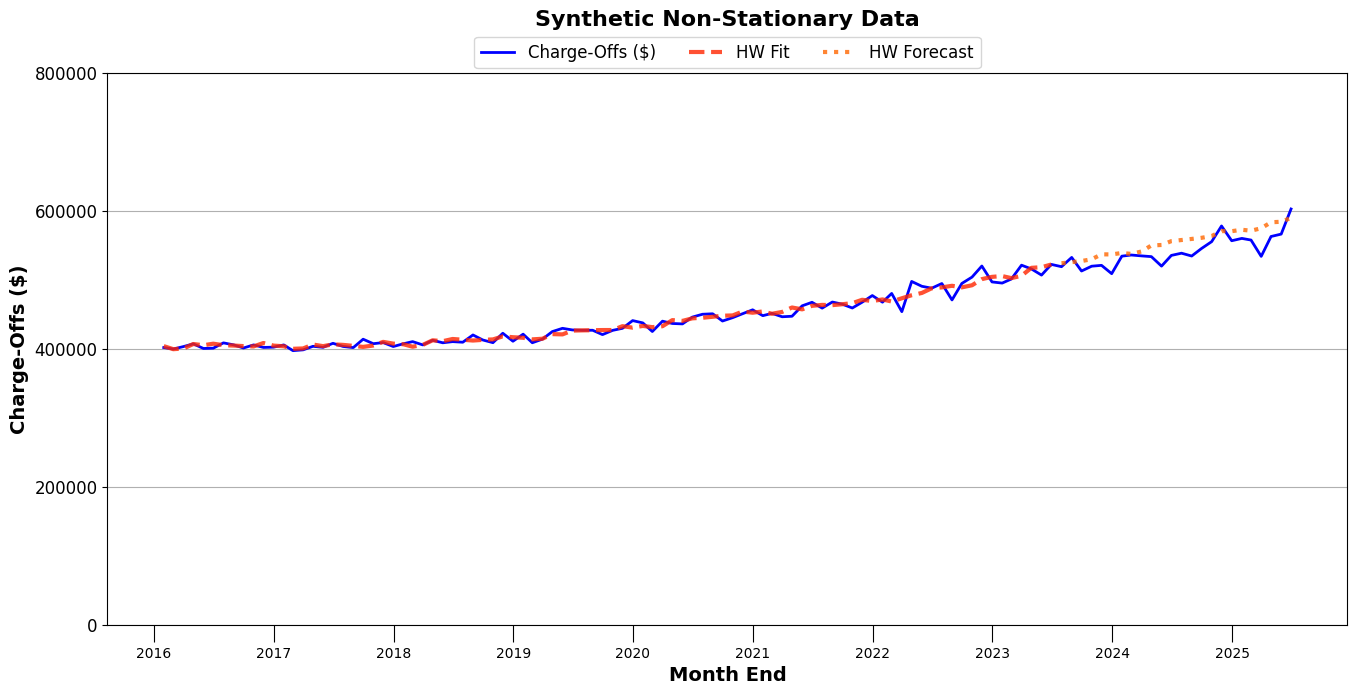

In [211]:
plot_data(non_stationary, 'data', yticks, colors, title, 'Charge-Offs ($)', hw=True)

##### ARIMA

In [212]:
best_model = arima_training(train_data)
non_stationary = arima_forecast(non_stationary, train_data, test_data, best_model)

ARIMA(0, 0, 1): AIC=2093.1, MAPE=3.99%
ARIMA(1, 0, 0): AIC=1923.2, MAPE=1.72%
ARIMA(1, 0, 1): AIC=1900.7, MAPE=1.50%
ARIMA(2, 0, 1): AIC=1902.4, MAPE=1.49%
ARIMA(1, 0, 2): AIC=1902.3, MAPE=1.49%
ARIMA(2, 0, 2): AIC=1902.2, MAPE=1.46%
ARIMA(0, 1, 1): AIC=1899.0, MAPE=2.74%
ARIMA(1, 1, 0): AIC=1897.8, MAPE=2.74%
ARIMA(1, 1, 1): AIC=1900.9, MAPE=2.74%
ARIMA(2, 1, 1): AIC=1900.5, MAPE=2.74%
ARIMA(1, 1, 2): AIC=1901.5, MAPE=2.73%
ARIMA(2, 1, 2): AIC=1903.6, MAPE=2.73%

Best ARIMA model: (1, 1, 0)
AIC: 1897.8, MAPE: 2.74%


In [213]:
# test the fitted values for the training dataset
test_fitted_values(non_stationary['data'][1:-24], non_stationary['arima_train'][1:-24])

MAPE: 1.65%
R²: 0.920
Directional Accuracy: 33.71%


In [214]:
# Test the forecasted values
test_fitted_values(non_stationary['data'][-24:], non_stationary['arima_forecast'][-24:])

MAPE: 3.98%
R²: -0.824
Directional Accuracy: 20.83%


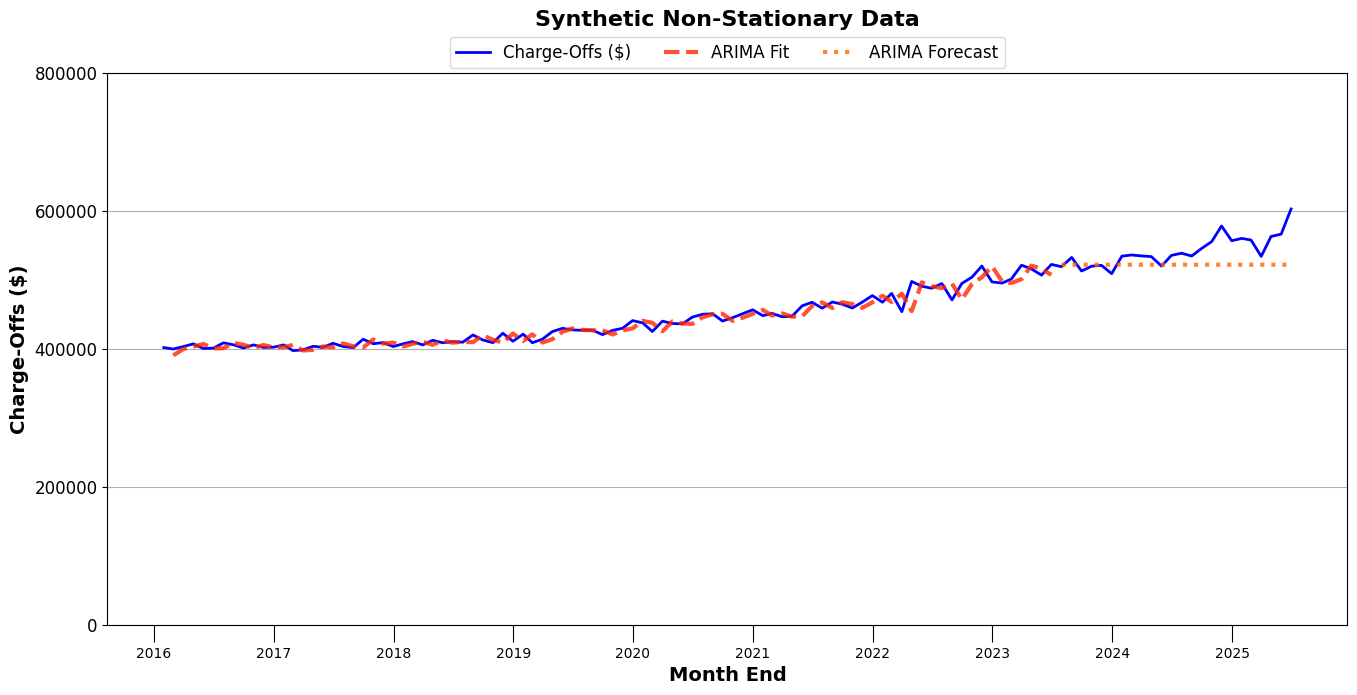

In [215]:
plot_data(non_stationary, 'data', yticks, colors, title, 'Charge-Offs ($)', arima=True)

##### SARIMA

In [216]:
best_model, best_seasonal_order = sarima_training(train_data)
non_stationary = sarima_forecast(non_stationary, train_data, test_data, best_model, best_seasonal_order)

SARIMA(1,0,0)(1,0,1,12): AIC=1930.4, MAPE=2.75% | Forecast range: $0 to $521,260
SARIMA(1,0,1)(1,0,1,12): AIC=1907.4, MAPE=2.51% | Forecast range: $0 to $513,603
SARIMA(0,0,1)(1,0,1,12): AIC=2525.1, MAPE=26.23% | Forecast range: $0 to $440,868
SARIMA(2,0,1)(1,0,1,12): AIC=1908.7, MAPE=2.50% | Forecast range: $0 to $513,603
SARIMA(1,0,0)(0,0,1,12): AIC=1927.5, MAPE=2.73% | Forecast range: $0 to $518,672

Best SARIMA model: (1, 0, 1)(1, 0, 1, 12)
AIC: 1907.4, MAPE: 2.51%


In [217]:
# test the fitted values for the training dataset
test_fitted_values(non_stationary['data'][1:-24], non_stationary['sarima_train'][1:-24])

MAPE: 1.42%
R²: 0.939
Directional Accuracy: 24.72%


In [218]:
# Test the forecasted values
test_fitted_values(non_stationary['data'][-24:], non_stationary['sarima_forecast'][-24:])

MAPE: 4.75%
R²: -1.391
Directional Accuracy: 54.17%


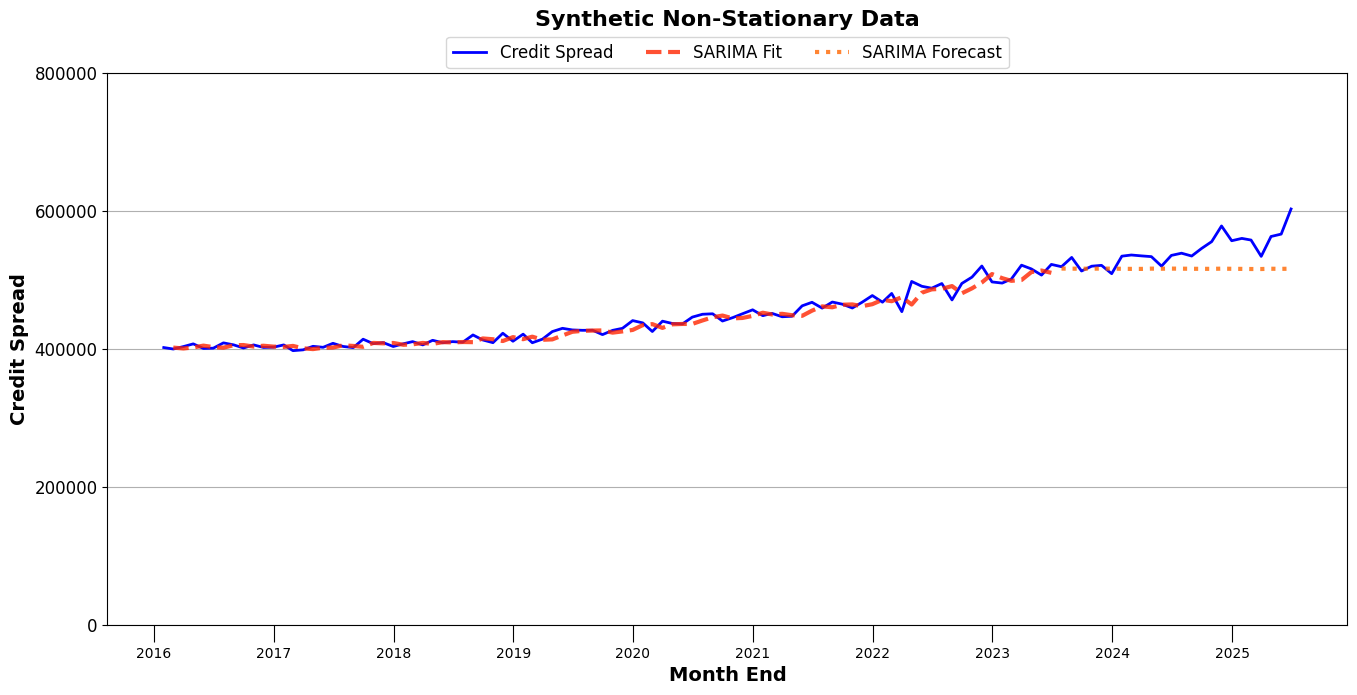

In [219]:
plot_data(non_stationary, 'data', yticks, colors, title, 'Credit Spread', sarima=True)